# Dataset

Dataset cleaning. Many of these functions iterate over the datapoints
more times
than necessary but we should only have to do this a few times at
most...

In [1]:
from io import open
from tqdm import tqdm
import itertools
import numpy as np
import spacy

import matplotlib.pyplot as plt
plt.ion()

## Function to read and extract conversations

In [10]:
def load_lines(filename='data/dialog/dialogs.txt'):
    print('Loading dialogs')
    return open(filename, encoding='utf-8').read().strip().split('\n')


def extract_conversations(lines):
    print('Get separate conversations...')
    conversations = []
    tmp_conv = []
    for line in lines:
        if len(line) > 2:  # "\r\n" - newline
            tmp_conv.append(line[:-1])
        else:
            conversations.append(tmp_conv)
            tmp_conv = []
    print('Number of conversations: ', len(conversations))
    return conversations


def structure_as_trigrams(conversations):
    print('Get trigrams (s_(i-1), s_i, s_(i+1)')
    trigrams = []
    for conv in conversations:
        for i in range(1, len(conv)-1):
            trigrams.append({'current': conv[i],
                             'pre': conv[i-1],
                             'post':conv[i+1]})

    print('Number of trigram examples (overlap): ', len(trigrams))
    return trigrams


Load all the lines from `data/dialogs.txt` and extract the different
conversations. Then arange the data in trigrams, here defined as three
sentences/utterences in sequential order.

A trigram contains
`trigram['current'], trigram['pre'], trigram['post']`, which
are the words in
the current sentece, previous sentence and next sentence
respectively.

In [3]:
lines = load_lines('data/dialogs.txt')
conversations = extract_conversations(lines)
trigrams = structure_as_trigrams(conversations)

print()
print('-'*50)
print('Lines in dataset: ', len(lines))
print('Conversations in dataset: ', len(conversations))
print('Total trigram data points:', len(trigrams))
print('Sample trigram:')
print(trigrams[0])

  0%|          | 0/399634 [00:00<?, ?it/s]

Loading dialogs
Get separate conversations...


 37%|███▋      | 9120/24400 [00:00<00:00, 91195.52it/s]

Number of conversations:  24400
Get trigrams (s_(i-1), s_i, s_(i+1)


100%|██████████| 24400/24400 [00:00<00:00, 116286.30it/s]

Number of trigram examples (overlap):  326493

--------------------------------------------------
Lines in dataset:  399634
Conversations in dataset:  24400
Total trigram data points: 326493
Sample trigram:
{'current': 'i have and i am so in love with the trailer already', 'pre': 'have you heard of the upcoming black panther movie', 'post': 'it looks remarkable so far'}


## Names

Here we us [Spacy](https://spacy.io/) and their Named Entity
recognition
software to replace names with the token `PERSON`.

There \*should\*
be much more efficient ways to do this but this is good enough
for now.  (It
took around 9 minutes on a Macbook pro.)

In [ ]:
def replace_names_with_PERSON(conversations, nlp):
    import time
    new_convs = []
    t = time.time()
    for conv in tqdm(conversations):
        # print(conv)
        tmp_conv = []
        doc = nlp(''.join(conv))
        for sentence in conv:
            s = sentence
            for x in doc.ents:
                if x.label_ in ['PERSON', 'ORG']:
                    # print(x.text,': ', x.label_)
                    s = s.replace(x.text, x.label_)
            tmp_conv.append(s)
        new_convs.append(tmp_conv)
    print(len(new_convs), ' conversations')
    print('took ', time.time() - t, ' seconds')
    return new_convs

nlp = spacy.load('en')
new_convs = replace_names_with_PERSON(conversations, nlp)

 99%|█████████▉| 24247/24400 [10:38<00:01, 106.19it/s]

Now `new_convs` contain the same conversations as before but with many names
(not all) have been replaced by `PERSON`. Lets extract the new trigram dataset
from this new conversation collection.

In [ ]:
new_trigrams = structure_as_trigrams(new_convs)
print('old trigrams: ', len(trigrams))
print('new trigrams: ', len(new_trigrams))

## Vocabulary

We use a vocabulary class from the [PyTorch Chatbot
Tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html)
with a
few minor changes. This vocabulary class takes the trigrams as input and
adds
and counts all the unique words in the dataset.

In [ ]:
class Voc:
    PAD_token = 0  # Used for padding short sentences
    SOS_token = 1  # Start-of-sentence token
    EOS_token = 2  # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {self.PAD_token: "PAD", self.SOS_token: "SOS", self.EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def add_trigrams(self, trigrams):
        print("Adding words to Vocab...")
        for tri in tqdm(trigrams):
            self.addSentence(tri['current'])
            self.addSentence(tri['pre'])
            self.addSentence(tri['post'])

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    def sort_words_by_count(self):
        return sorted(self.word2count.items(), key=lambda kv: kv[1])

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            print('Already Trimmed: ', self.min_count)
            return
        self.trimmed = True
        self.min_count = min_count

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {self.PAD_token: "PAD", self.SOS_token: "SOS", self.EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)



## Trimming

In [9]:
def trim_convs(convs, voc):
    keep_convs = []
    for conv in convs:
        keep = True
        for sentence in conv:
            # print(type(sentence)) # str
            for word in sentence.split(' '):
                if not word in voc.word2index:
                    keep = False
        if keep:
            keep_convs.append(conv)
    print('Conversations: {}/{}'.format(len(keep_convs), len(convs)))
    print('Conversations: {}%'.format(len(keep_convs)*100 / len(convs)))
    print('total Conv after trim:', len(keep_convs))
    return keep_convs

Now lets trim the dataset such that uncommon words, which in this
regard would
be considered noise, are thrown away.

First the data should
consist of coherent utterances with sequential
dependencies, these are the
different conversations. If we remove a datapoint in
the middle of a
conversation that will impede the coherence of all datapoints
around it. Thus we
need, as a first action at least, try to delete the complete
conversation where
a word we trimmed out is present. If `word_count` is 2 that
means that all words
in the processed dataset appear at least 2 times, in other
words all
conversations containing a word that appears less than 2 times in the
entire
dataset are "thrown" away.

Lets do this for a minimum word count from 2 to 7
and see how large dataset is
left.

In [11]:
# Trim vocabulary of words used less than min_count
# Then trim conversations containing those words
vocab_size = []
keep_conversations = []
trigram_size = []
min_counts = [2,3,4,5,6,7]
for min_count in min_counts:
    new_voc = Voc('new')
    new_voc.add_trigrams(new_trigrams)
    # print('Vocab size: ', new_voc.num_words)
    new_voc.trim(min_count)
    # print('Trimmed vocab size: ', new_voc.num_words)
    newest_convs = trim_convs(new_convs, new_voc)
    trigrams = structure_as_trigrams(newest_convs)
    vocab_size.append(new_voc.num_words)
    keep_conversations.append(len(newest_convs))
    trigram_size.append(len(trigrams))

  4%|▍         | 14431/326493 [00:00<00:04, 69210.40it/s]

Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 79320.23it/s]


keep_words 48823 / 51221 = 0.9532


  0%|          | 0/326493 [00:00<?, ?it/s]

Conversations: 22264/24400
Conversations: 91.24590163934427%
total Conv after trim: 22264
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  297595
Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 77715.15it/s]


keep_words 46253 / 51221 = 0.9030


  0%|          | 0/326493 [00:00<?, ?it/s]

Conversations: 20321/24400
Conversations: 83.2827868852459%
total Conv after trim: 20321
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  271551
Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 77902.01it/s]


keep_words 27230 / 51221 = 0.5316


  2%|▏         | 7937/326493 [00:00<00:04, 79367.62it/s]

Conversations: 12314/24400
Conversations: 50.467213114754095%
total Conv after trim: 12314
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  149894
Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 79721.59it/s]


keep_words 26131 / 51221 = 0.5102


  2%|▏         | 7663/326493 [00:00<00:04, 76617.65it/s]

Conversations: 11648/24400
Conversations: 47.73770491803279%
total Conv after trim: 11648
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  141441
Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 78620.71it/s]


keep_words 24912 / 51221 = 0.4864


  2%|▏         | 7401/326493 [00:00<00:04, 74003.19it/s]

Conversations: 10974/24400
Conversations: 44.97540983606557%
total Conv after trim: 10974
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  132663
Adding words to Vocab...


100%|██████████| 326493/326493 [00:04<00:00, 79567.70it/s]


keep_words 20325 / 51221 = 0.3968
Conversations: 9208/24400
Conversations: 37.73770491803279%
total Conv after trim: 9208
Get trigrams (s_(i-1), s_i, s_(i+1)
Number of trigram examples (overlap):  107589


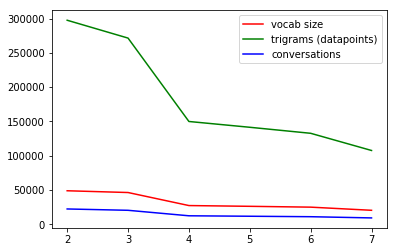

In [12]:
plt.plot(min_counts, vocab_size,  'r', label='vocab size')
plt.plot(min_counts, trigram_size, 'g', label='trigrams (datapoints)')
plt.plot(min_counts, keep_conversations, 'b', label='conversations')
plt.legend()
plt.show()

# Results

As seen in the image both the number of datapoints and the vocabulary size decreases substantially in size when throwing away conversations with words used less than 4 times in the corpus. The question then really comes down to the ration between datapoints and the size of the network trained, related to the size of the vocabulary, i.e the word embedding space.


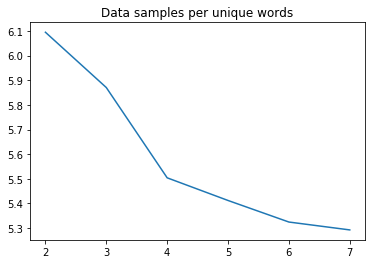

In [15]:
ratio = []
for v, t in zip(vocab_size, trigram_size):
    ratio.append(t/v)

plt.plot(min_counts, ratio)
plt.title('Data samples per unique words')
plt.show()

In [16]:
np.save('PERSON_convs', new_convs)

# Summary

Trimming the data and using only conversations comprised of words used at least N times yields:

-------------

N = 3

46253 unique words

20321 Conversations (83.3% of all conversations)

-------------

N = 4

27230 unique words

12314 Conversations (50.5% of all conversations)